In [2]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_anomaly_detection

In [3]:
%presentation_style

In [4]:
%%capture

%set_random_seed 12

2025-02-23 15:19:55.844125: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-23 15:19:55.991394: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-23 15:19:56.805399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-23 15:19:56.805601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-23 15:19:56.906834: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [5]:
%load_latex_macros


$\renewcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\renewcommand{\amax}{{\text{argmax}}}$
$\renewcommand{\P}{{\mathbb{P}}}$
$\renewcommand{\E}{{\mathbb{E}}}$
$\renewcommand{\R}{{\mathbb{R}}}$
$\renewcommand{\Z}{{\mathbb{Z}}}$
$\renewcommand{\N}{{\mathbb{N}}}$
$\renewcommand{\C}{{\mathbb{C}}}$
$\renewcommand{\abs}[1]{{ \left| #1 \right| }}$
$\renewcommand{\simpl}[1]{{\Delta^{#1} }}$


# Anomaly Detection via Reconstruction Error
<img src="_static/images/aai-institute-cover.png" alt="Snow" style="width:100%;">

In [6]:
import ipywidgets as widgets
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px


from ipywidgets import interact
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import IsolationForest
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KernelDensity
from tensorflow import keras
from tqdm import tqdm

from tfl_training_anomaly_detection.exercise_tools import (
    evaluate, 
    get_kdd_data, 
    get_house_prices_data, 
    create_distributions, 
    contamination, 
    perform_rkde_experiment, 
    get_mnist_data
)
from tfl_training_anomaly_detection.vae import VAE, build_decoder_mnist, build_encoder_minst, build_contaminated_minst

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (5, 5)


## Exercise: Anomaly Detection on the MNIST Data Set
MNIST is one of the most iconic data sets in the history of machine learning.
It contains 70000 samples of $28\times 28$ grayscale images of handwritten digits.
Because of its moderate complexity and good visualizability it is well suited to study the behavior of machine learning
algorithms in higher dimensional spaces.

While originally created for classification (optical character recognition), we can build an anomaly detection data set
by corrupting some of the images.


### Pre-processing
We first need to obtain the MNIST data set and prepare an anomaly detection set from it.
Note that the data set is n row vector format.
Therefore, we work with $28\times 28 = 784$ dimensional data points.

In [7]:
# load MNIST Data Set
mnist = get_mnist_data()

data = mnist['data']
print('data.shape: {}'.format(data.shape))
target = mnist['target'].astype(int)

data.shape: (70000, 784)


### Build contaminated Data Sets

We prepared a function that does the job for us.
It corrupts a prescribed portion of the data by introducing a rotation, noise or a blackout of some part of the image.

First, we need to transform the data into image format.

In [8]:
X = data.reshape(-1, 28, 28, 1)/255

### Train/Test-Split
We will only corrupt the test set, hence we will perform the train-test split beforehand.
We separate a relatively small test set so that we can use as much as possible from the data to obtain high quality
representations.

In [9]:
test_size = .1
X_train, X_test, target_train, target_test = train_test_split(X, target, test_size=test_size)

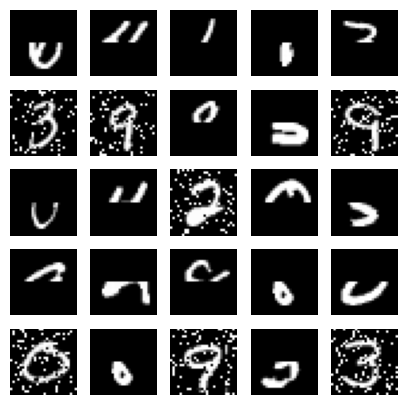

In [10]:
X_test, y_test = build_contaminated_minst(X_test)

# Visualize contamination
anomalies = X_test[y_test != 0]
selection = np.random.choice(len(anomalies), 25)

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(5, 5))
for img, ax in zip(anomalies[selection], axes.flatten()):
    ax.imshow(img, 'gray')
    ax.axis('off')
plt.show()

### Autoencoder
Let us finally train an autoencoder model. We replicate the model given in the
[Keras documentation](https://keras.io/examples/generative/vae/) and apply it in a synthetic outlier detection scenario
based on MNIST.

in the vae package we provide the implementation of the VAE. Please take a look into the source code to see how
the minimization of the KL divergence is implemented.

### Create Model

In [11]:
latent_dim = 3
vae = VAE(decoder=build_decoder_mnist(latent_dim=latent_dim), encoder=build_encoder_minst(latent_dim=latent_dim))

In [12]:
## Inspect model architecture
vae.encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 14, 14, 32)           320       ['input_2[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 7, 7, 64)             18496     ['conv2d[0][0]']              
                                                                                                  
 flatten (Flatten)           (None, 3136)                 0         ['conv2d_1[0][0]']            
                                                                                            

In [13]:
## Inspect model architecture
vae.decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 3136)              12544     
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 64)        36928     
 anspose)                                                        
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 28, 28, 32)        18464     
 Transpose)                                                      
                                                                 
 conv2d_transpose_2 (Conv2D  (None, 28, 28, 1)         289 

In [20]:
# train model
n_epochs = 30

vae.compile(optimizer=keras.optimizers.Adam(learning_rate=.001))
history = vae.fit(X_train, epochs=n_epochs, batch_size=128)

Epoch 1/30
493/493 [==============================] - 42s 82ms/step - loss: 33.6886 - reconstruction_loss: 33.6014 - kl_loss: 1.2096e-04
Epoch 2/30
493/493 [==============================] - 39s 79ms/step - loss: 33.6582 - reconstruction_loss: 33.5940 - kl_loss: 8.6020e-05
Epoch 3/30
493/493 [==============================] - 39s 79ms/step - loss: 33.5802 - reconstruction_loss: 33.5898 - kl_loss: 6.2075e-05
Epoch 4/30
493/493 [==============================] - 39s 80ms/step - loss: 33.6100 - reconstruction_loss: 33.5879 - kl_loss: 5.4290e-05
Epoch 5/30
493/493 [==============================] - 39s 79ms/step - loss: 33.6353 - reconstruction_loss: 33.5871 - kl_loss: 4.4816e-05
Epoch 6/30
493/493 [==============================] - 38s 78ms/step - loss: 33.6045 - reconstruction_loss: 33.5826 - kl_loss: 4.9039e-05
Epoch 7/30
493/493 [==============================] - 38s 76ms/step - loss: 33.6700 - reconstruction_loss: 33.5837 - kl_loss: 3.1311e-05
Epoch 8/30
493/493 [=====================

### Inspect Result

In [21]:
import matplotlib.pyplot as plt

# normal distribution should not have a favorite direction. Let's check this.
# Let's walk through the latent space to investigate different slices and rotations
def plot_latent_space(vae: VAE, n: int=10, figsize: float=10):
    """Plot sample images from 2D slices of latent space
    
    @param vae: vae model
    @param n: sample nXn images per slice
    @param figsize: figure size
    
    """
    # permute the matrix in the second and third iteration
    for perm in [[0, 1, 2], [1, 0, 2], [2, 1, 0]]:
        # display a n*n 2D manifold of digits
        digit_size = 28
        scale = 1.0
        figure = np.zeros((digit_size * n, digit_size * n))
        # linearly spaced coordinates corresponding to the 2D plot
        # of digit classes in the latent space
        grid_x = np.linspace(-scale, scale, n)
        grid_y = np.linspace(-scale, scale, n)[::-1]  # reverse from 1 to -1

        for i, yi in enumerate(grid_y):
            for j, xi in enumerate(grid_x):
                # sample through the latent space and fix one component
                z_sample = np.array([[xi, yi, 0]])
                # permutate / shift the z_sample to fix different components
                z_sample[0] = z_sample[0][perm]
                x_decoded = vae.decoder.predict(z_sample)
                digit = x_decoded[0].reshape(digit_size, digit_size)
                figure[
                    i * digit_size : (i + 1) * digit_size,
                    j * digit_size : (j + 1) * digit_size,
                ] = digit

        plt.figure(figsize=(figsize, figsize))
        start_range = digit_size // 2
        end_range = n * digit_size + start_range
        pixel_range = np.arange(start_range, end_range, digit_size)
        sample_range_x = np.round(grid_x, 1)
        sample_range_y = np.round(grid_y, 1)
        plt.xticks(pixel_range, sample_range_x)
        plt.yticks(pixel_range, sample_range_y)
        plt.xlabel("z[{}]".format(perm[0]))
        plt.ylabel("z[{}]".format(perm[1]))
        plt.gca().set_title('z[{}] = 0'.format(perm[2]))
        plt.imshow(figure, cmap="Greys_r")
        plt.show()

1/1 [==============================] - 0s 14ms/step


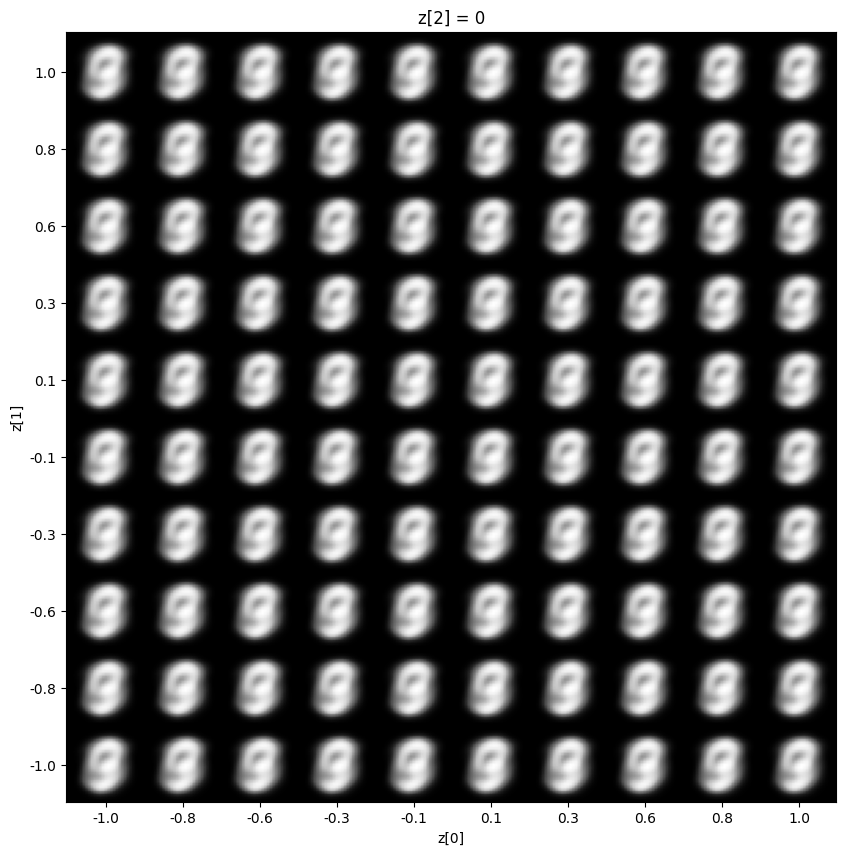

1/1 [==============================] - 0s 15ms/step


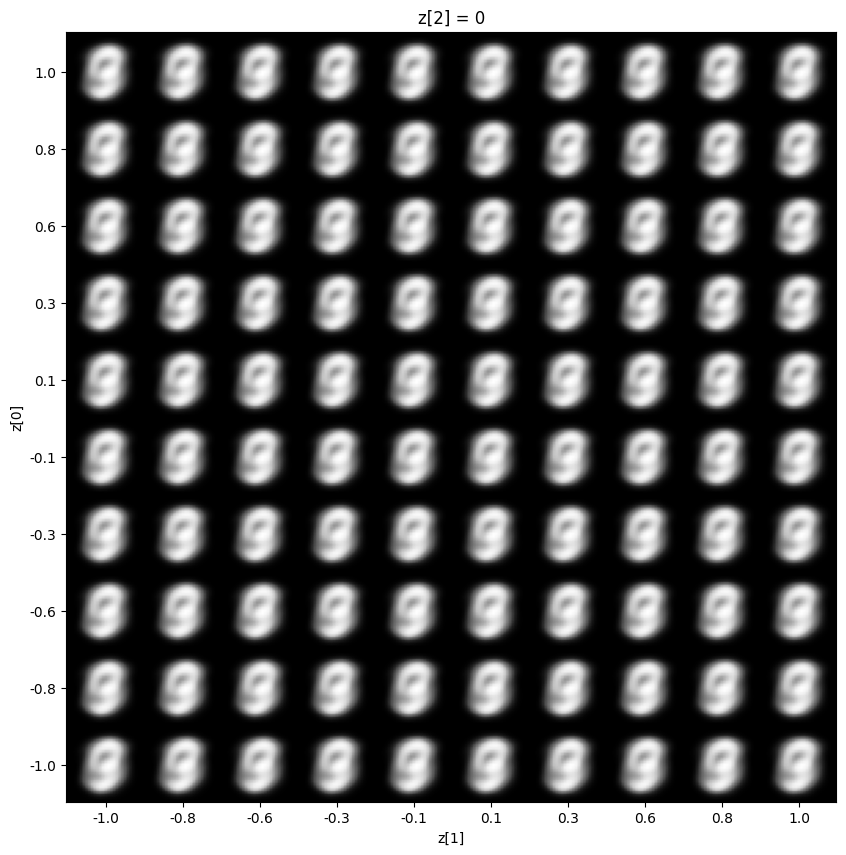

1/1 [==============================] - 0s 14ms/step


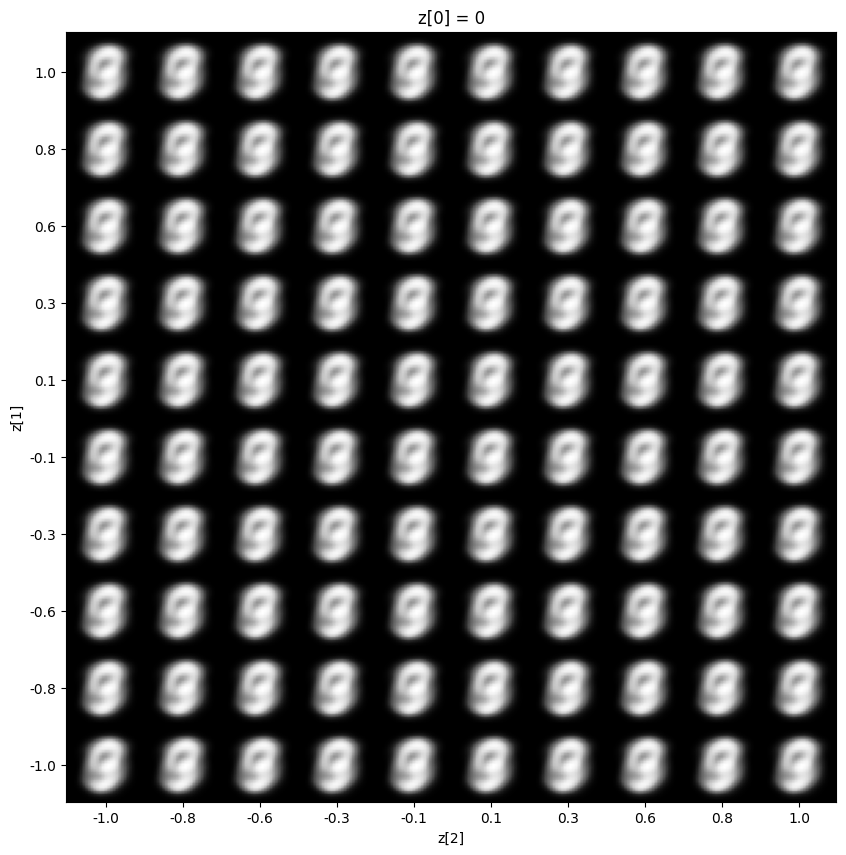

In [22]:
plot_latent_space(vae)

In [17]:
# Principal components
pca = PCA()
latents = vae.encoder.predict(X_train)[2]
pca.fit(latents)

kwargs = {'x_{}'.format(i): (-1., 1.) for i in range(latent_dim)}


@widgets.interact(**kwargs)
def explore_latent_space(**kwargs):
    """Widget to explore latent space from given start position
    """
    center_img = pca.transform(np.zeros([1,latent_dim]))

    latent_rep_pca =  center_img + np.array([[kwargs[key] for key in kwargs]])
    latent_rep = pca.inverse_transform(latent_rep_pca)
    img = vae.decoder(latent_rep).numpy().reshape(28, 28)

    fig, ax = plt.subplots()
    ax.axis('off')
    ax.axis('off')

    ax.imshow(img,cmap='gray', vmin=0, vmax=1)
    plt.show()

1969/1969 [==============================] - 6s 3ms/step


interactive(children=(FloatSlider(value=0.0, description='x_0', max=1.0, min=-1.0), FloatSlider(value=0.0, des…

In [ ]:
latents = vae.encoder.predict(X_train)[2]
scatter = px.scatter_3d(x=latents[:, 0], y=latents[:, 1], z=latents[:, 2], color=target_train)

scatter.show()

In [ ]:
latents = vae.encoder.predict(X_test)[2]
scatter = px.scatter_3d(x=latents[:, 0], y=latents[:, 1], z=latents[:, 2], color=y_test)

scatter.show()

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test)


In [ ]:
n_samples = 10

s = np.random.choice(range(len(X_val)), n_samples)
s = X_val[s]
#s = [X_train_img[i] for i in s]

fig, axes = plt.subplots(nrows=2, ncols=n_samples, figsize=(10, 2))
for img, ax_row in zip(s, axes.T):
    x = vae.decoder.predict(vae.encoder.predict(img.reshape(1, 28, 28, 1))[2]).reshape(28, 28)
    diff = x - img.reshape(28, 28)
    error = (diff * diff).sum()
    ax_row[0].axis('off')
    ax_row[1].axis('off')
    ax_row[0].imshow(img,cmap='gray', vmin=0, vmax=1)
    ax_row[1].imshow(x, cmap='gray', vmin=0, vmax=1)
    ax_row[1].set_title('E={:.1f}'.format(error))

plt.tight_layout()
plt.show()

In [ ]:
from sklearn import metrics
y_test_bin = y_test.copy()
y_test_bin[y_test != 0] = 1
y_val_bin = y_val.copy()
y_val_bin[y_val != 0] = 1
# Evaluate
reconstruction = vae.decoder.predict(vae.encoder(X_val)[2])
rerrors = (reconstruction - X_val).reshape(-1, 28*28)
rerrors = (rerrors * rerrors).sum(axis=1)

# Let's calculate scores if any anomaly is present
if np.any(y_val_bin == 1):
    eval = evaluate(y_val_bin.astype(int), rerrors.astype(float))
    pr, rec, thr = eval['PR']
    f1s = (2 * ((pr * rec)[:-1]/(pr + rec)[:-1]))
    threshold = thr[np.argmax(f1s)]
    print('Optimal threshold: {}'.format(threshold))

    reconstruction = vae.decoder.predict(vae.encoder(X_test)[2])
    reconstruction_error = (reconstruction - X_test).reshape(-1, 28*28)
    reconstruction_error = (reconstruction_error * reconstruction_error).sum(axis=1)


    classification = (reconstruction_error > threshold).astype(int)

    print('Precision: {}'.format(metrics.precision_score(y_test_bin, classification)))
    print('Recall: {}'.format(metrics.recall_score(y_test_bin, classification)))
    print('F1: {}'.format(metrics.f1_score(y_test_bin, classification)))

    metrics.confusion_matrix(y_test_bin, classification)
else:
    reconstruction_error = None


### Sort Data by Reconstruction Error

In [ ]:
if reconstruction_error is not None:
    combined = list(zip(X_test, reconstruction_error))
    combined.sort(key = lambda x: x[1])


### Show Top Autoencoder Outliers

In [ ]:
if reconstruction_error is not None:
    n_rows = 10
    n_cols = 10
    n_samples = n_rows*n_cols

    samples = [c[0] for c in combined[-n_samples:]]

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(2*n_cols, 2*n_rows))
    for img, ax in zip(samples, axes.reshape(-1)):
        ax.axis('off')
        ax.imshow(img.reshape((28,28)), cmap='gray', vmin=0, vmax=1)

    plt.show()


<img src="_static/images/aai-institute-cover.png" alt="Snow" style="width:100%;">